In [2]:
import polars as pl
from scipy.stats import ttest_ind, spearmanr
import pandas as pd

# 載入資料
df = pl.read_csv("SAML-D.csv")

# Label 欄位實際名稱是 "Is_laundering"
df0 = df.filter(pl.col("Is_laundering") == 0)
df1 = df.filter(pl.col("Is_laundering") == 1)

# 排除非數值欄位
exclude_cols = {
    "Sender_account", "Receiver_account", "Time", "Date",
    "Payment_currency", "Received_currency",
    "Sender_bank_location", "Receiver_bank_location",
    "Payment_type", "Is_laundering", "Laundering_type"
}
numeric_cols = [
    col for col in df.columns
    if df[col].dtype in [pl.Float64, pl.Int64] and col not in exclude_cols
]

# 統計分析
results = []
for col in numeric_cols:
    a = df0[col].to_numpy()
    b = df1[col].to_numpy()
    t_stat, p_t = ttest_ind(a, b, equal_var=False)
    corr, p_s = spearmanr(df[col], df["Is_laundering"])
    results.append({
        "變數": col,
        "t 值": round(t_stat, 4),
        "t 檢定 p 值": round(p_t, 4),
        "Spearman ρ": round(corr, 4),
        "Spearman p 值": round(p_s, 4),
    })

# 顯示結果
summary_df = pd.DataFrame(results)
print(summary_df.sort_values(by="t 檢定 p 值"))


       變數     t 值  t 檢定 p 值  Spearman ρ  Spearman p 值
0  Amount -7.5516       0.0     -0.0019           0.0


In [8]:
import polars as pl
import pandas as pd
from scipy.stats import ttest_ind, spearmanr, chi2_contingency
from tabulate import tabulate

# 讀取資料
df = pl.read_csv("SAML-D.csv")

# 將 polars 轉為 pandas 處理統計分析
df_pd = df.to_pandas()

# 初始化結果儲存
ttest_results = []
corr_results = []
chi2_results = []

# 數值欄位統計：t-test + Spearman
for col in df_pd.columns:
    if col == "Is_laundering":
        continue
    if pd.api.types.is_numeric_dtype(df_pd[col]):
        group0 = df_pd[df_pd["Is_laundering"] == 0][col].dropna()
        group1 = df_pd[df_pd["Is_laundering"] == 1][col].dropna()
        if len(group0) > 0 and len(group1) > 0:
            t_stat, p_t = ttest_ind(group0, group1, equal_var=False)
            rho, p_s = spearmanr(df_pd[col], df_pd["Is_laundering"])
            ttest_results.append([col, round(t_stat, 4), round(p_t, 4)])
            corr_results.append([col, round(rho, 4), round(p_s, 4)])

# 類別欄位統計：卡方檢定
for col in df_pd.columns:
    if col == "Is_laundering":
        continue
    if pd.api.types.is_object_dtype(df_pd[col]) or pd.api.types.is_categorical_dtype(df_pd[col]):
        contingency_table = pd.crosstab(df_pd[col], df_pd["Is_laundering"])
        if contingency_table.shape[0] > 1 and contingency_table.shape[1] == 2:
            try:
                chi2, p, dof, _ = chi2_contingency(contingency_table)
                chi2_results.append([col, round(chi2, 4), round(p, 4)])
            except:
                continue

# 顯示 t-test 結果
print("\n📊 數值型欄位：t-test 與洗錢標籤的關聯")
print(tabulate(ttest_results, headers=["欄位", "t 值", "p 值"], tablefmt="fancy_grid"))

# 顯示 Spearman 結果
print("\n📈 數值型欄位：Spearman 與洗錢標籤的相關")
print(tabulate(corr_results, headers=["欄位", "Spearman ρ", "p 值"], tablefmt="fancy_grid"))

# 顯示卡方檢定結果
print("\n🧮 類別型欄位：卡方檢定與洗錢標籤的關聯")
print(tabulate(chi2_results, headers=["欄位", "Chi-square", "p 值"], tablefmt="fancy_grid"))


C:\Users\Leon\AppData\Local\Temp\ipykernel_12324\2790892833.py:34: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df_pd[col]) or pd.api.types.is_categorical_dtype(df_pd[col]):



📊 數值型欄位：t-test 與洗錢標籤的關聯
╒══════════════════╤═════════╤════════╕
│ 欄位             │    t 值 │   p 值 │
╞══════════════════╪═════════╪════════╡
│ Sender_account   │ -5.0271 │ 0      │
├──────────────────┼─────────┼────────┤
│ Receiver_account │  1.1938 │ 0.2326 │
├──────────────────┼─────────┼────────┤
│ Amount           │ -7.5516 │ 0      │
╘══════════════════╧═════════╧════════╛

📈 數值型欄位：Spearman 與洗錢標籤的相關
╒══════════════════╤══════════════╤════════╕
│ 欄位             │   Spearman ρ │   p 值 │
╞══════════════════╪══════════════╪════════╡
│ Sender_account   │       0.0016 │ 0      │
├──────────────────┼──────────────┼────────┤
│ Receiver_account │      -0.0004 │ 0.2401 │
├──────────────────┼──────────────┼────────┤
│ Amount           │      -0.0019 │ 0      │
╘══════════════════╧══════════════╧════════╛

🧮 類別型欄位：卡方檢定與洗錢標籤的關聯
╒════════════════════════╤═════════════════╤════════╕
│ 欄位                   │      Chi-square │   p 值 │
╞════════════════════════╪═════════════════╪════════╡
│ Time   

先看欄位有啥

In [1]:
import polars as pl

# 設定檔案路徑
file_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"

# 讀取 CSV 資料
df = pl.read_csv(file_path)

# 顯示所有欄位名稱
print("📌 資料欄位名稱：")
print(df.columns)

# 顯示欄位資料型別與前幾筆值
print("\n📌 各欄位型別與前 5 筆資料：")
print(df.head(5))
print("\n📌 欄位型別資訊：")
print(df.dtypes)


📌 資料欄位名稱：
['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type']

📌 各欄位型別與前 5 筆資料：
shape: (5, 12)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Time     ┆ Date      ┆ Sender_ac ┆ Receiver_ ┆ … ┆ Receiver_ ┆ Payment_t ┆ Is_launde ┆ Launderin │
│ ---      ┆ ---       ┆ count     ┆ account   ┆   ┆ bank_loca ┆ ype       ┆ ring      ┆ g_type    │
│ str      ┆ str       ┆ ---       ┆ ---       ┆   ┆ tion      ┆ ---       ┆ ---       ┆ ---       │
│          ┆           ┆ i64       ┆ i64       ┆   ┆ ---       ┆ str       ┆ i64       ┆ str       │
│          ┆           ┆           ┆           ┆   ┆ str       ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 10:35:19 ┆ 2022-10-0 ┆ 872473195 ┆ 27693

肘部法（Elbow Method）
用不同的 k 值跑 KMeans，看「分群誤差 SSE（平方誤差和）」隨 k 的變化曲線。當 k 增加時，SSE 會下降，但下降到某個點就會趨緩，這個「彎曲處」就是建議的群數。

✅ 肘部法：只用 Amount 欄位分群（Polars 加速）

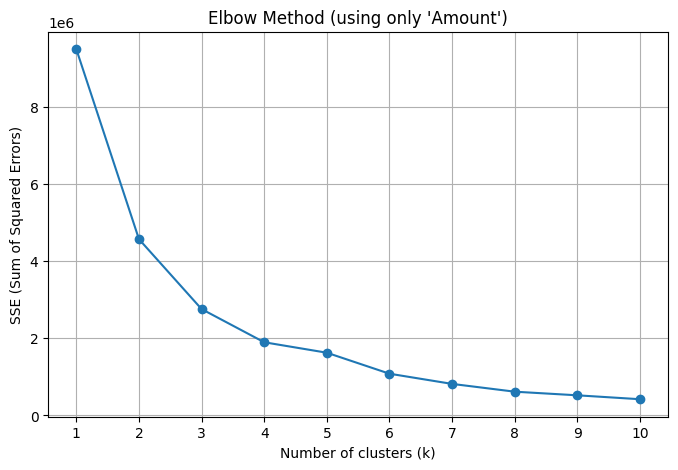

In [2]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. 讀取資料 ===
file_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"
df = pl.read_csv(file_path)

# === 2. 選取並處理 'Amount' 欄位 ===
X = df.select(["Amount"]).drop_nulls().to_numpy()  # Polars → NumPy 陣列

# === 3. 資料標準化（避免數值大小影響） ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 4. 執行肘部法 ===
sse = []
k_range = range(1, 11)  # 測試 1 到 10 群

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  # inertia_ 為群內誤差平方和

# === 5. 繪圖 ===
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method (using only 'Amount')")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.xticks(k_range)
plt.grid(True)
plt.show()


✅ 任務目標：
對使用 KMeans (k=3) 所得到的群組，畫出每個群組的金額分佈圖（boxplot），觀察交易金額如何分層。

C:\Users\Leon\AppData\Local\Temp\ipykernel_15572\1641033640.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(amount_lists, labels=[f"Cluster {i}" for i in range(3)])


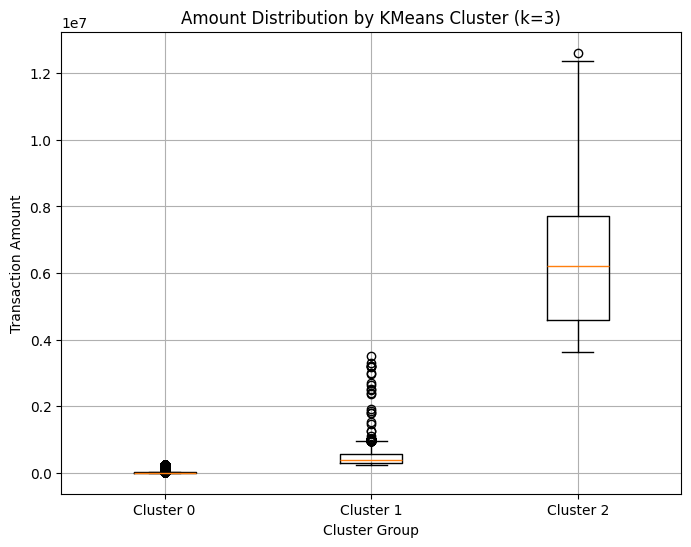

In [8]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. 讀取資料 ===
file_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"
df = pl.read_csv(file_path)

# === 2. 選取 'Amount' 欄位並標準化 ===
df_clean = df.select(["Amount"]).drop_nulls()
X = df_clean.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. KMeans 分群（k=3）===
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# === 4. 合併分群結果 ===
df_with_labels = df_clean.with_columns([
    pl.Series("Cluster", labels)
])

# === 5. 改用 flat group_by + filter 回圈來手動取出每群金額 ===
amount_lists = []

for i in range(3):  # k=3 群
    amount_i = df_with_labels.filter(pl.col("Cluster") == i).select("Amount").to_series().to_list()
    amount_lists.append(amount_i)

# === 6. 畫 Boxplot ===
plt.figure(figsize=(8, 6))
plt.boxplot(amount_lists, labels=[f"Cluster {i}" for i in range(3)])
plt.title("Amount Distribution by KMeans Cluster (k=3)")
plt.ylabel("Transaction Amount")
plt.xlabel("Cluster Group")
plt.grid(True)
plt.show()


| 群組            | 金額分布            | 解讀                        |
| ------------- | --------------- | ------------------------- |
| **Cluster 0** | 全部集中在低金額，幾乎無離群值 | **小額交易群**，可能為日常轉帳或分散式交易手法 |
| **Cluster 1** | 金額略高，有不少離群值     | **中額交易群**，可能包含公司或跨帳戶操作    |
| **Cluster 2** | 金額大幅提升，分布廣且上限極高 | **大額群體／高風險集團**，可能是可疑交易來源  |


✅ 任務 ①：統計每個 Cluster 的金額摘要
我們會列出每群的：

筆數（count）

平均金額（mean）

標準差（std）

最小值（min）

中位數（median）

最大值（max）

✅ 任務 ②：將 Cluster 標籤加回原始資料，並輸出成 SAML-D_clustered.csv


In [10]:
import polars as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# === 1. 讀取原始資料 ===
file_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv"
df = pl.read_csv(file_path)

# === 2. 準備標準化後的金額資料 ===
df_amount = df.select(["Amount"]).drop_nulls()
X = df_amount.to_numpy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. 執行 KMeans（k=3） ===
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# === 4. 將 Cluster 結果加回原始資料（與原資料筆數一致） ===
df_with_cluster = df.with_columns([
    pl.Series(name="Cluster", values=labels)
])

# === 5. 計算每群的金額統計摘要 ===
stats = df_with_cluster.group_by("Cluster").agg([
    pl.count("Amount").alias("Count"),
    pl.mean("Amount").alias("Mean"),
    pl.std("Amount").alias("Std"),
    pl.min("Amount").alias("Min"),
    pl.median("Amount").alias("Median"),
    pl.max("Amount").alias("Max")
]).sort("Cluster")

# 顯示統計結果
print("📊 Cluster 統計摘要：")
print(stats)

# === 6. 匯出含 Cluster 的資料表 ===
output_path = r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\非監督學習\SAML-D_clustered.csv"
df_with_cluster.write_csv(output_path)
print(f"\n✅ 已成功匯出至：{output_path}")


📊 Cluster 統計摘要：
shape: (3, 7)
┌─────────┬─────────┬───────────────┬───────────────┬───────────┬────────────┬───────────┐
│ Cluster ┆ Count   ┆ Mean          ┆ Std           ┆ Min       ┆ Median     ┆ Max       │
│ ---     ┆ ---     ┆ ---           ┆ ---           ┆ ---       ┆ ---        ┆ ---       │
│ i32     ┆ u32     ┆ f64           ┆ f64           ┆ f64       ┆ f64        ┆ f64       │
╞═════════╪═════════╪═══════════════╪═══════════════╪═══════════╪════════════╪═══════════╡
│ 0       ┆ 9489333 ┆ 8017.199716   ┆ 10010.691016  ┆ 3.73      ┆ 6103.01    ┆ 230139.97 │
│ 1       ┆ 15488   ┆ 452371.955935 ┆ 205848.394512 ┆ 230155.77 ┆ 393558.845 ┆ 3507884.1 │
│ 2       ┆ 31      ┆ 6.6611e6      ┆ 2.6087e6      ┆ 3.6340e6  ┆ 6.2132e6   ┆ 1.2618e7  │
└─────────┴─────────┴───────────────┴───────────────┴───────────┴────────────┴───────────┘

✅ 已成功匯出至：C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\非監督學習\SAML-D_clustered.csv


對 Cluster 2 中的帳戶進行名單列出（Sender / Receiver）
→ 找出那些 31 筆交易是哪幾個帳戶搞的


In [11]:
import polars as pl
from pathlib import Path

# === 1. 設定檔案路徑 ===
csv_path = Path(r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\非監督學習\SAML-D_clustered.csv")

# === 2. 讀取資料 ===
df = pl.read_csv(csv_path)

# === 3. 篩選 Cluster = 2（高風險交易群）===
cluster2_df = df.filter(pl.col("Cluster") == 2)

# === 4. 擷取重要欄位（帳戶、金額、支付方式與地點）===
result = cluster2_df.select([
    "Date", "Time",
    "Sender_account", "Receiver_account",
    "Amount", "Payment_type",
    "Sender_bank_location", "Receiver_bank_location"
])

# === 5. 顯示或存檔結果（可選）===
print(result)

# 若想存成 CSV 可加入以下一行：
result.write_csv(r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\非監督學習\Cluster2_高風險交易清單.csv")


shape: (31, 8)
┌────────────┬──────────┬────────────┬────────────┬──────────┬────────────┬────────────┬───────────┐
│ Date       ┆ Time     ┆ Sender_acc ┆ Receiver_a ┆ Amount   ┆ Payment_ty ┆ Sender_ban ┆ Receiver_ │
│ ---        ┆ ---      ┆ ount       ┆ ccount     ┆ ---      ┆ pe         ┆ k_location ┆ bank_loca │
│ str        ┆ str      ┆ ---        ┆ ---        ┆ f64      ┆ ---        ┆ ---        ┆ tion      │
│            ┆          ┆ i64        ┆ i64        ┆          ┆ str        ┆ str        ┆ ---       │
│            ┆          ┆            ┆            ┆          ┆            ┆            ┆ str       │
╞════════════╪══════════╪════════════╪════════════╪══════════╪════════════╪════════════╪═══════════╡
│ 2022-10-12 ┆ 16:12:51 ┆ 5057689301 ┆ 3267846600 ┆ 6.2139e6 ┆ Credit     ┆ UK         ┆ UK        │
│            ┆          ┆            ┆            ┆          ┆ card       ┆            ┆           │
│ 2022-11-05 ┆ 23:51:26 ┆ 4197215987 ┆ 7510608716 ┆ 5.9712e6 ┆ Debit card ┆ 

In [16]:
import polars as pl

# === 1. 載入資料 ===
raw_df = pl.read_csv(r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\SAML-D.csv")
cluster2_df = pl.read_csv(r"C:\Users\Leon\Desktop\程式語言資料\python\TD-UF\Anti Money Laundering Transaction Data (SAML-D)\非監督學習\Cluster2_高風險交易清單.csv")

# === 2. 合併比對條件：用 Sender、Receiver、Amount、Date、Time 當關鍵欄位 ===
# （⚠️ 因為沒有明確交易 ID，我們用這些欄位做模糊連結）
merged = cluster2_df.join(
    raw_df.select(["Time", "Date", "Sender_account", "Receiver_account", "Amount", "Is_laundering"]),
    on=["Time", "Date", "Sender_account", "Receiver_account", "Amount"],
    how="inner"
)

# === 3. 計算中獎筆數 ===
total = merged.shape[0]
fraud = merged.filter(pl.col("Is_laundering") == 1).shape[0]
ratio = fraud / total if total > 0 else 0

# === 4. 印出結果 ===
print(f"📄 原始對上清單共 {total} 筆")
print(f"🚨 其中被標記為洗錢：{fraud} 筆")
print(f"🎯 命中率：{ratio:.2%}")


📄 原始對上清單共 31 筆
🚨 其中被標記為洗錢：31 筆
🎯 命中率：100.00%
